In [1]:
import torch
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, VECM
import statsmodels.tsa.vector_ar.vecm as vecm 
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.vector_ar.util as var_tool
from pandarallel import pandarallel
from multiprocessing import Pool
import tqdm
import pickle
import itertools
from collections import defaultdict, OrderedDict
import copy
import matplotlib.pyplot as plt
from datetime import date, timedelta

from help_function import *

pandarallel.initialize(progress_bar=False)
%load_ext rpy2.ipython

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# 1. Data Pre-Process

In [25]:
df_list = []
blockFrom = 11008985
blockGap =   100000
blockMax = 12108985

while blockFrom <= blockMax:
    # print(blockFrom)
    blockTo = blockFrom + blockGap
    df = pd.read_csv(f'data/crawled/chainlink/chainlink_on_chain_eth_usd_{blockFrom}_{blockTo}.csv', index_col=False)
    df['current'] = df['current'].apply(lambda x: hex2int(x)*10e-8)
    df = df.groupby("blockNum").parallel_apply(lambda x: np.mean(x['current']))
    df_list.append(df)
    blockFrom = blockTo

raw_chainlink_on_chain_eth_usd_df = pd.concat(df_list)
raw_chainlink_on_chain_eth_usd_df

blockNum
11009295     3408.670139
11009296     3408.507812
11009299     3408.800000
11009362     3417.749822
11009364     3417.500000
                ...     
12204450    20779.050000
12204451    20779.680679
12204452    20779.680679
12204453    20779.876159
12204457    20779.978080
Length: 64020, dtype: float64

In [ ]:
raw_chainlink_on_chain_eth_usd_df

In [40]:
df_list = []
blockFrom = 12187956 #12188099
blockGap = 100000
blockMax = 14838875

while blockFrom <= blockMax:
    # print(blockFrom)
    blockTo = blockFrom + blockGap
    df = pd.read_csv(f'data/crawled/chainlink/chainlink_eth_usd_{blockFrom}_{blockTo}.csv', index_col=False)
    df['current'] = df['current'].apply(lambda x: hex2int(x)*10e-9)
    df = df.groupby("blockNum").parallel_apply(lambda x: np.mean(x['current']))
    df_list.append(df)

    blockFrom = blockTo

raw_chainlink_off_chain_eth_usd_df = pd.concat(df_list)
raw_chainlink_off_chain_eth_usd_df

blockNum
12188099    2112.520328
12188218    2110.229796
12188261    2111.307606
12188347    2122.114085
12188491    2118.448296
               ...     
14887562    1827.056516
14887571    1838.291375
14887732    1828.678677
14887768    1825.222332
14887805    1815.987110
Length: 27410, dtype: float64

In [ ]:
df_list = []
blockFrom = 11008985
blockGap = 50000
blockMax = 14838875

def reformat_log_maker_dao_median(raw_data):
    data = copy.deepcopy(raw_data)
    for col_name in 'price age'.split(' '):
        data[col_name] = raw_data[col_name].map(hex2int)
    return data


while blockFrom <= blockMax:
    # print(blockFrom)
    blockTo = blockFrom + blockGap
    df = pd.read_csv(f'data/crawled/makerdao/maker_dao_eth_usd_median_{blockFrom}_{blockTo}.csv', index_col=False)
    cut_gap = int(len(df['Data'].iloc[0])/2)
    cut_start = 0
    for i, new_col in enumerate("price age".split(" ")):
        cut_end = cut_start + cut_gap
        df[new_col] = df['Data'].apply(lambda x: x[cut_start:cut_end])
        cut_start = cut_end
    del df['Data']
    df.sort_values(['blockNum', 'index'])

    df = reformat_log_maker_dao_median(df)
    df.price = df.price * 10e-19

    df = df.groupby("blockNum").parallel_apply(lambda x: np.mean(x['price']))

    blockFrom = blockTo
    df_list.append(df)

raw_makerdao_eth_usd_df = pd.concat(df_list)
raw_makerdao_eth_usd_df

In [ ]:
def reformat_log_uniswap(raw_data):
    data = copy.deepcopy(raw_data)
    for col_name in 'topic0 reserve0 reserve1'.split(' '):
        data[col_name] = raw_data[col_name].map(hex2int)
    data['reserve0'] = data['reserve0'] / 10**6 
    data['reserve1'] = data['reserve1'] / 10**(22-4)
    return data

df_list = []
# v3 12376891 才启动
blockFrom = 11008985
blockGap = 50000
blockMax = 14838875

while blockFrom <= blockMax:
    blockTo = blockFrom + blockGap
    df = pd.read_csv(f'data/crawled/uniswap/uniswap_v2_eth_usdc_{blockFrom}_{blockTo}.csv', index_col=False)
    df['index'] = df['blockNum']
    df['blockNum'] = df['reserve1']
    cut_point = int(len(df['reserve0'].iloc[0])/2)
    df['reserve1'] = df['reserve0'].apply(lambda x: x[cut_point:])
    df['reserve0'] = df['reserve0'].apply(lambda x: x[:cut_point])
    df = reformat_log_uniswap(df)
    df['price'] = df['reserve0']/ df['reserve1']
    df.sort_values(['blockNum', 'index'])
    df_list.append(df)
    # print(blockFrom)
    blockFrom = blockTo
raw_uniswap_eth_usd_df = pd.concat(df_list)
raw_uniswap_eth_usd_df = raw_uniswap_eth_usd_df.groupby("blockNum").parallel_apply(lambda x: np.mean(x['price']))
raw_uniswap_eth_usd_df

In [ ]:
agg_df = pd.concat(
    [
        raw_uniswap_eth_usd_df, 
        raw_makerdao_eth_usd_df, 
        raw_chainlink_on_chain_eth_usd_df, 
        raw_chainlink_off_chain_eth_usd_df
    ],
    axis=1
)
agg_df.columns = 'uniswap makerdao chainlink_on chainlink_off'.split(" ")
# agg_df = agg_df.loc[raw_uniswap_eth_usd_df.index[0]:(raw_uniswap_eth_usd_df.index[-1]+1)].fillna(method='ffill')
agg_df.to_csv("data/price/vertical_analysis/agg_df.csv")

# 2. Latency Measurement

In [37]:
agg_df = pd.read_csv("data/price/vertical_analysis/agg_df.csv")
agg_df

,blockNum,uniswap,makerdao,chainlink_on,chainlink_off
0,11008985,341.693004,NaN,NaN,NaN
1,11008988,341.687300,NaN,NaN,NaN
2,11008989,341.682039,NaN,NaN,NaN
3,11008990,341.680043,NaN,NaN,NaN
4,11008991,341.673623,NaN,NaN,NaN
...,...,...,...,...,...
1850899,14887562,NaN,NaN,NaN,1827.056516
1850900,14887571,NaN,NaN,NaN,1838.291375
1850901,14887732,NaN,NaN,NaN,1828.678677
1850902,14887768,NaN,NaN,NaN,1825.222332


In [41]:
print(agg_df[['chainlink_on', 'blockNum']].dropna().tail())
agg_df[['chainlink_off', 'blockNum']].dropna().head()

        chainlink_on  blockNum
772483  20779.050000  12204450
772484  20779.680679  12204451
772485  20779.680679  12204452
772486  20779.876159  12204453
772487  20779.978080  12204457


,chainlink_off,blockNum
762263,2112.520328,12188099
762345,2110.229796,12188218
762378,2111.307606,12188261
762439,2122.114085,12188347
762533,2118.448296,12188491


In [42]:
agg_df = pd.read_csv("data/price/vertical_analysis/agg_df.csv")
block_num_df = pd.DataFrame(list(range(11009580, 14858983)))
block_num_df.columns = ['blockNum']
agg_df = block_num_df.merge(agg_df, how='left', on='blockNum')

agg_df = agg_df.fillna(method='ffill').set_index('blockNum', drop=True)
agg_df = np.log(agg_df)
on_chain_df = agg_df.loc[11009634:12188099, 'uniswap makerdao chainlink_on'.split(' ')]
off_chain_df = agg_df.loc[12188099:14858983, 'uniswap makerdao chainlink_off'.split(' ')]

In [29]:
on_chain_df

,uniswap,makerdao,chainlink_on
blockNum,,,
11009634,5.828791,5.828857,8.129536
11009635,5.828675,5.828857,8.129322
11009636,5.828600,5.828857,8.129322
11009637,5.828622,5.828857,8.129322
11009638,5.828615,5.828857,8.129322
...,...,...,...
12188095,7.654602,7.660585,9.963712
12188096,7.654608,7.660585,9.963712
12188097,7.654608,7.660585,9.963712


In [ ]:
avg_block_per_day = 6424
sub_split_size = avg_block_per_day

split_num = 6
df_split_each_range = avg_block_per_day * split_num

In [ ]:
#  model
fitted_var_model_list = []
for tmp_log_price_df in tqdm.tqdm(np.split(on_chain_df, df_split_index(on_chain_df, each_range=df_split_each_range))):
    if len(tmp_log_price_df.index) < sub_split_size: continue
    tmp_log_price_df = tmp_log_price_df.reset_index(drop=True)

    # make stationary
    log_f_diff = tmp_log_price_df.diff().dropna() 
    log_f_diff = log_f_diff.reset_index(drop=True)

    # VAR model
    fitted_model_result = main_multi_p(log_f_diff, split_num=split_num, model='var')
    for tmp_model in fitted_model_result:
        fitted_var_model_list.append(tmp_model)
    
    del fitted_model_result, log_f_diff

save_data = fitted_var_model_list

with open("./data/analysis/vertical/on_chain.pickle", "wb") as output_file:
    pickle.dump(save_data, output_file)

In [ ]:
#  model

# del save_data
fitted_var_model_list = []
counter = 0
for tmp_log_price_df in tqdm.tqdm(np.split(off_chain_df, df_split_index(off_chain_df, each_range=df_split_each_range))):
    if len(tmp_log_price_df.index) < sub_split_size: continue
    tmp_log_price_df = tmp_log_price_df.reset_index(drop=True)

    # make stationary
    log_f_diff = tmp_log_price_df.diff().dropna() 
    log_f_diff = log_f_diff.reset_index(drop=True)

    # VAR model
    fitted_model_result = main_multi_p(log_f_diff, split_num=split_num, model='var')
    for tmp_model in fitted_model_result:
        fitted_var_model_list.append(tmp_model)
    
    del fitted_model_result, log_f_diff

save_data = fitted_var_model_list

with open("./data/analysis/vertical/off_chain.pickle", "wb") as output_file:
    pickle.dump(save_data, output_file)

In [ ]:

tmp_log_price_df

In [ ]:
irf_periods = 100
var_irf_list = []
with open("./data/analysis/vertical/on_chain.pickle", "rb") as output_file:
    models = pickle.load(output_file)
for model_i in tqdm.tqdm(models):
    tmp_df = get_model_irf_df(model_i, irf_periods, "uniswap makerdao chainlink_on".split(' '), return_data='weighted_avg_latency')
    var_irf_list.append(tmp_df)
del models
with open("./data/analysis/vertical/on_chain_irf.pickle", "wb") as output_file:
    pickle.dump(var_irf_list, output_file)
del var_irf_list

In [ ]:
tmp_df

In [ ]:
irf_periods = 100
var_irf_list = []
error_irf_count = 0
with open("./data/analysis/vertical/off_chain.pickle", "rb") as output_file:
    models = pickle.load(output_file)
for model_i in tqdm.tqdm(models):
    try:
        tmp_df = get_model_irf_df(model_i, irf_periods, "uniswap makerdao chainlink_off".split(' '), return_data='weighted_avg_latency')
    except ValueError:
        error_irf_count += 1
        pass # use previous round data
    var_irf_list.append(tmp_df)
del models
with open("./data/analysis/vertical/off_chain_irf.pickle", "wb") as output_file:
    pickle.dump(var_irf_list, output_file)
del var_irf_list

In [ ]:
error_irf_count

# 3. Latency Analysis

(<AxesSubplot:>,
 makerdao        18.577143
 chainlink_on    13.912915
 dtype: float64,
 (186, 2))

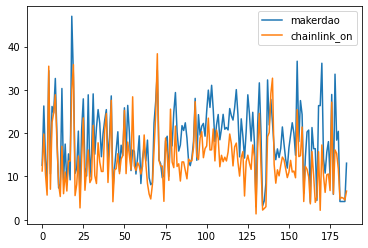

In [47]:
with open("./data/analysis/vertical/on_chain_irf.pickle", "rb") as output_file:
    on_chain_var_irf_list = pickle.load(output_file)
on_chain_latency_df = get_latency_df2("uniswap", ["makerdao", "chainlink_on"], on_chain_var_irf_list)
del on_chain_var_irf_list
on_chain_length = on_chain_latency_df.shape[0]
on_chain_latency_df.plot(), on_chain_latency_df.agg("mean"), on_chain_latency_df.shape

(<AxesSubplot:>,
 makerdao         27.245371
 chainlink_off    16.158210
 dtype: float64,
 (420, 2))

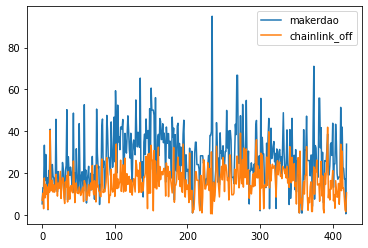

In [48]:
with open("./data/analysis/vertical/off_chain_irf.pickle", "rb") as output_file:
    off_chain_var_irf_list = pickle.load(output_file)
off_chain_latency_df = get_latency_df2("uniswap", ["makerdao", "chainlink_off"], off_chain_var_irf_list)
del off_chain_var_irf_list
off_chain_latency_df.plot(), off_chain_latency_df.agg("mean"), off_chain_latency_df.shape

In [49]:
daterange(date(2020, 10, 7), date(2022, 5, 28))

<generator object daterange at 0x7fe1c52e40b0>

In [50]:
on_chain_latency_df.columns = off_chain_latency_df.columns = ['makerdao', 'chainlink']
join_df = pd.concat([on_chain_latency_df, off_chain_latency_df])
join_df = join_df.reset_index(drop=True)
join_df['time'] = [i for i in range(join_df.shape[0])]
join_df['block_num'] = [11009580 + i * 6424 for i in range(join_df.shape[0])]
join_df['off_chain_agg'] = [0 if i <= on_chain_latency_df.shape[0] else 1 for i in range(join_df.shape[0]) ]
join_df['date'] = list(daterange(date(2020, 10, 2), date(2022, 5, 31)))
join_df_col = join_df.columns
join_df

,makerdao,chainlink,time,block_num,off_chain_agg,date
0,12.558404,11.251530,0,11009580,0,2020-10-02
1,26.264808,19.784913,1,11016004,0,2020-10-03
2,13.987853,10.581607,2,11022428,0,2020-10-04
3,9.110857,5.677741,3,11028852,0,2020-10-05
4,34.426606,35.462878,4,11035276,0,2020-10-06
...,...,...,...,...,...,...
601,22.243186,12.760589,601,14870404,1,2022-05-26
602,17.334281,8.099437,602,14876828,1,2022-05-27
603,17.334281,2.462763,603,14883252,1,2022-05-28
604,0.567329,1.576633,604,14889676,1,2022-05-29


In [51]:
join_df[join_df['off_chain_agg'] == 1].head()

,makerdao,chainlink,time,block_num,off_chain_agg,date
187,13.030618,10.428696,187,12210868,1,2021-04-07
188,13.030618,3.000000,188,12217292,1,2021-04-08
189,33.349941,17.688959,189,12223716,1,2021-04-09
190,16.428650,8.195721,190,12230140,1,2021-04-10
191,28.903615,14.587070,191,12236564,1,2021-04-11


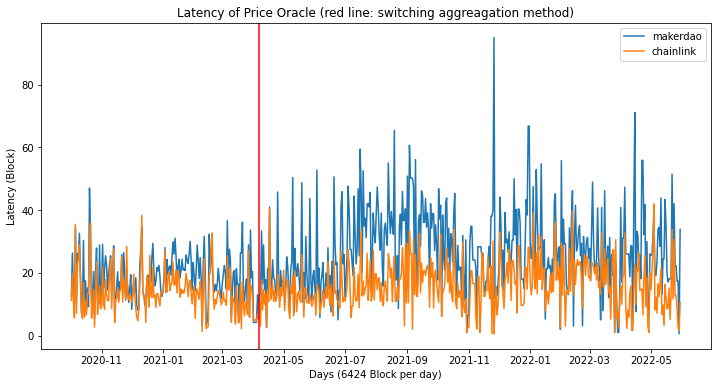

In [6]:
ax = join_df[['makerdao', 'chainlink',"date"]].set_index("date").plot(
    title='Latency of Price Oracle (red line: switching aggreagation method)', 
    ylabel='Latency (Block)', 
    xlabel='Days (6424 Block per day)',
    figsize=(12,6)
) # .iloc[:400,:]
# ax.axvline(on_chain_latency_df.index[-1], color='red')
ax.axvline(date(2021, 4, 6), color='red')   # 

fig = ax.get_figure()
fig.savefig("VerticalLatencyComparision.pdf")

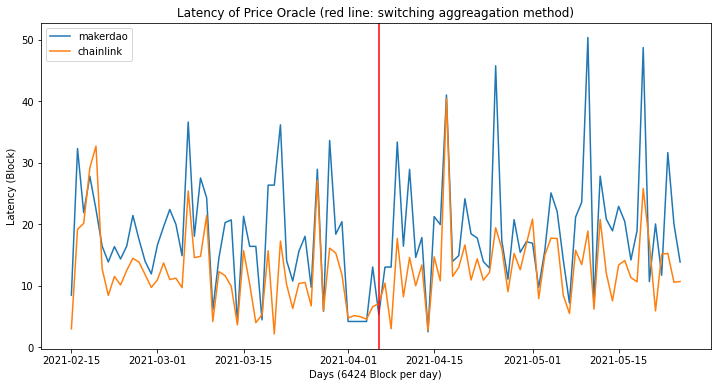

In [7]:
ax = join_df[['makerdao', 'chainlink',"date"]].iloc[(186-50):(186+50),:].set_index("date").plot(
    title='Latency of Price Oracle (red line: switching aggreagation method)', 
    ylabel='Latency (Block)', 
    xlabel='Days (6424 Block per day)',
    figsize=(12,6)
) 
ax.axvline(date(2021, 4, 6), color='red')
# ax.axvline(50, color='red')
fig = ax.get_figure()
fig.savefig("VerticalLatencyComparisionReduced.pdf")

R[write to console]: Loading required package: carData

R[write to console]: 
Please cite as: 


R[write to console]:  Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

R[write to console]:  R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 


R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric





Call:
lm(formula = diff ~ off_chain_agg, data = join_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.912  -2.683   1.030   3.977  15.529 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -5.2430     0.9056  -5.789 8.52e-08 ***
off_chain_agg  -1.2958     1.3072  -0.991    0.324    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.531 on 98 degrees of freedom
Multiple R-squared:  0.009927,	Adjusted R-squared:  -0.0001756 
F-statistic: 0.9826 on 1 and 98 DF,  p-value: 0.324



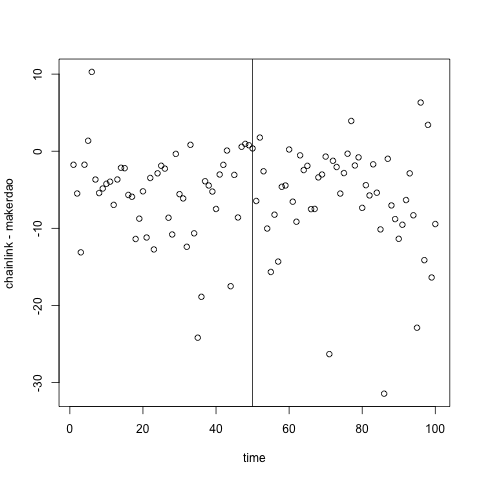

In [9]:
%%R -i join_df,join_df_col
colnames(join_df) <- unlist(join_df_col)
rdf <- data.frame(join_df)
library(ggplot2); library(car); library(stargazer); library(scales); library(lmtest); library(sandwich)


treatment_point <- 186
after_treatment_len <- 420
total_len <- treatment_point + after_treatment_len

# Analyse raw data
join_df['diff']=join_df['chainlink']-join_df['makerdao']  # This is the difference between the two plots and shoould be easier to see treatment effect
join_df['log_diff']=log(join_df['chainlink']/join_df['makerdao'])  # This is the difference between the two plots and shoould be easier to see treatment effect

decrase_range <- TRUE

if (decrase_range) {

    new_size <- 50

    join_df <- join_df[(treatment_point-new_size):(treatment_point+new_size-1),]
    
    treatment_point <- new_size
    after_treatment_len <- new_size
    total_len <- treatment_point + after_treatment_len

    rownames(join_df) <- 1:nrow(join_df)

    join_df$time <- 1:nrow(join_df)
    
}

# pdf("TreatmentEffectComparision.pdf", width=8, height=5)
plot(join_df$time,join_df$diff,xlab="time",ylab="chainlink - makerdao")
abline(v=treatment_point)
# dev.off() 
analysis1=lm(diff~off_chain_agg, data=join_df)
summary(analysis1)

In [10]:
%%R
# install.packages("skedastic")
library(skedastic)
model <- lm(join_df$diff~join_df$time)
skedastic::white_lm(model)

# A tibble: 1 x 5
  statistic p.value parameter method       alternative
      <dbl>   <dbl>     <dbl> <chr>        <chr>      
1      2.99   0.224         2 White's Test greater    


In [11]:
%%R
before=join_df$diff[join_df$off_chain_agg==0]
after=join_df$diff[join_df$off_chain_agg==1]

pdf("VerticalTreatmentEffectComparision.pdf", width=8, height=5)

# 

plot(join_df$time, join_df$diff-mean(before),xlab="Day (6424 blocks per day)",ylab="Treatment effect", main='The vertical line is the day switching aggregation method') # This sets raw.diff sales to have mean zero before.
abline(v=52)
lines(1:52,rep(0,52),lwd=2)
abline(h=0,lty=3)
se=summary(analysis1)$coefficients[2,2]  # And the next few lines add in some uncertainty

for(b in 0:100){lines(53:100,rep(0,48)+mean(after)-mean(before)-1.96*se+2*1.96*se*(b/100),col="gray")}
lines(53:100,rep(0,48)+mean(after)-mean(before),lwd=2)
points(join_df$time, join_df$diff-mean(before))

dev.off() 

quartz_off_screen 
                2 
